In [1]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, top_k_accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("base_features.csv")
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
malvertising             3085
scanning_host             231
exploit_kit                82
cc_skimming                12
exploit_source              4
web_attack                  2
Name: count, dtype: int64

In [3]:
labels_with_few_samples = ['web_attack', 'exploit_source']
df = df[~(df['label'].isin(labels_with_few_samples))]
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
malvertising             3085
scanning_host             231
exploit_kit                82
cc_skimming                12
Name: count, dtype: int64

In [4]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index), uniques.tolist()

In [5]:
_, labels = column_adjustor(df['label'])
{i: label for i, label in enumerate(labels)}

{0: 'phishing',
 1: 'malware_hosting',
 2: 'command_and_control',
 3: 'exploit_kit',
 4: 'scanning_host',
 5: 'malvertising',
 6: 'cc_skimming',
 7: 'spam',
 8: 'good'}

In [6]:
all_accuracy_scores = {}
all_shap_values = {"base_features": [], "cascade_1": [], "cascade_2": [], "cascade_3": [], "all_features": []}

## Base Features

1
2
3
4
5
6
7
8
9
10


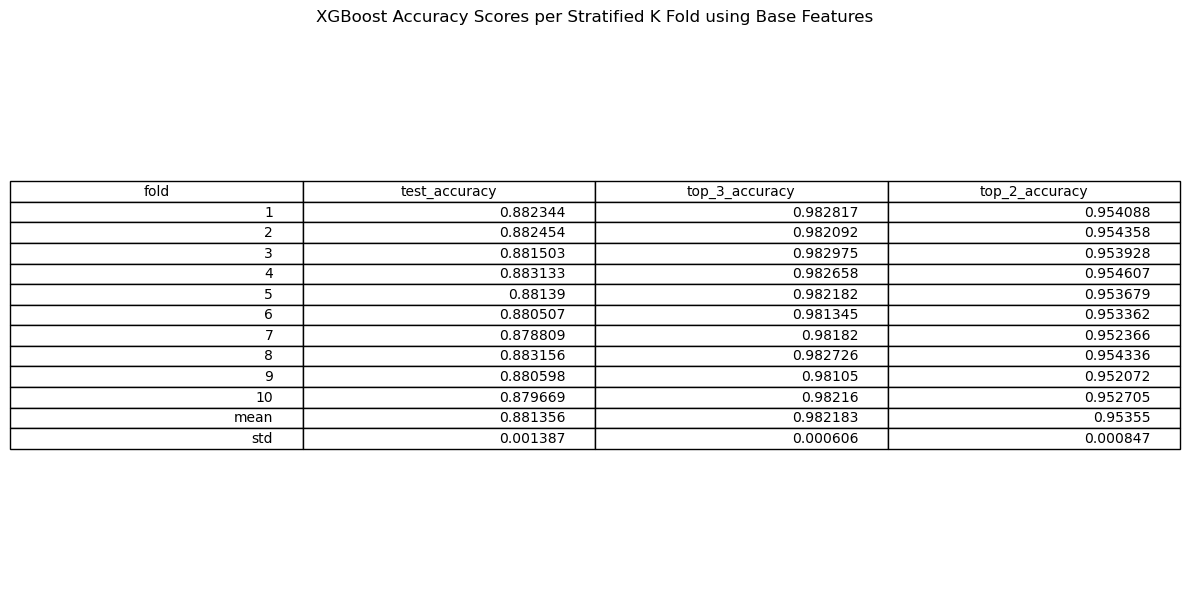

In [15]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold + 1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title("XGBoost Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [19]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
ratio_digits_hostname     15.069792%               
hostname_length           9.474973%                
domain_length             8.308259%                
tld_transfer_price        8.017989%                
url_length                7.890378%                
ratio_digits_domain       7.338187%                
unique_url_nums           5.099430%                
unique_url_letters        4.492242%                
num_hyphens               3.740989%                
tld                       3.134716%                
ratio_nums_chars          3.042498%                
tld_renew_price           3.009394%                
number_subdomains         2.992130%                
num_tlds_in_url           2.772811%                
tld_register_price        2.522030%                
ratio_digits_url          2.256300%                
num_queries               1.840385%                
num_semicolons            1.630644%                
number_under

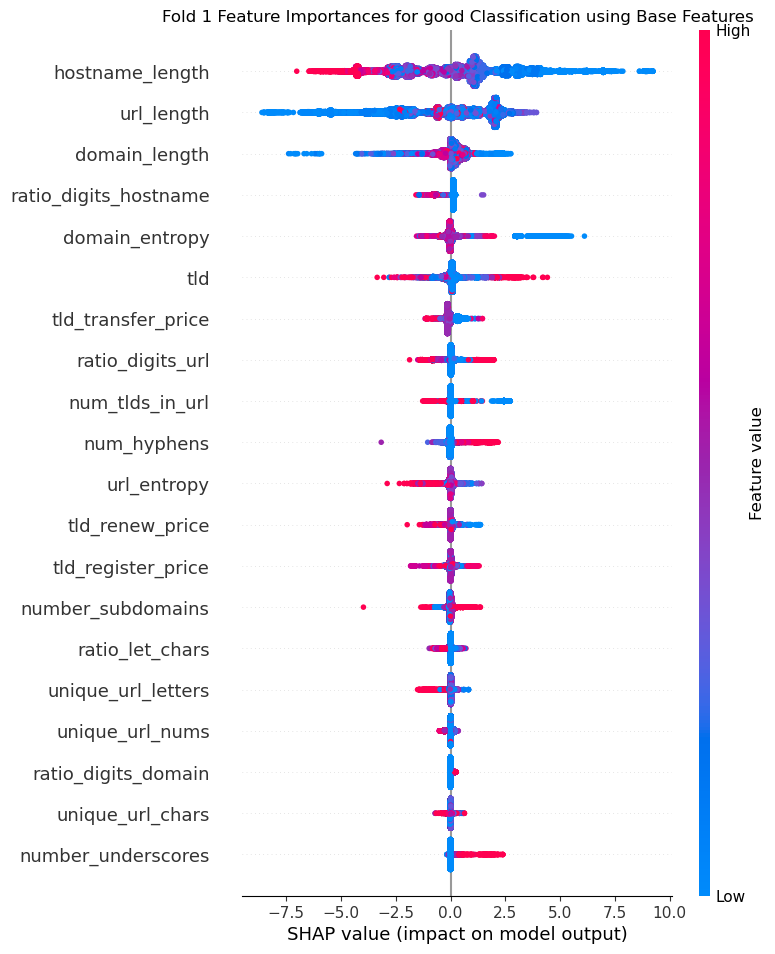

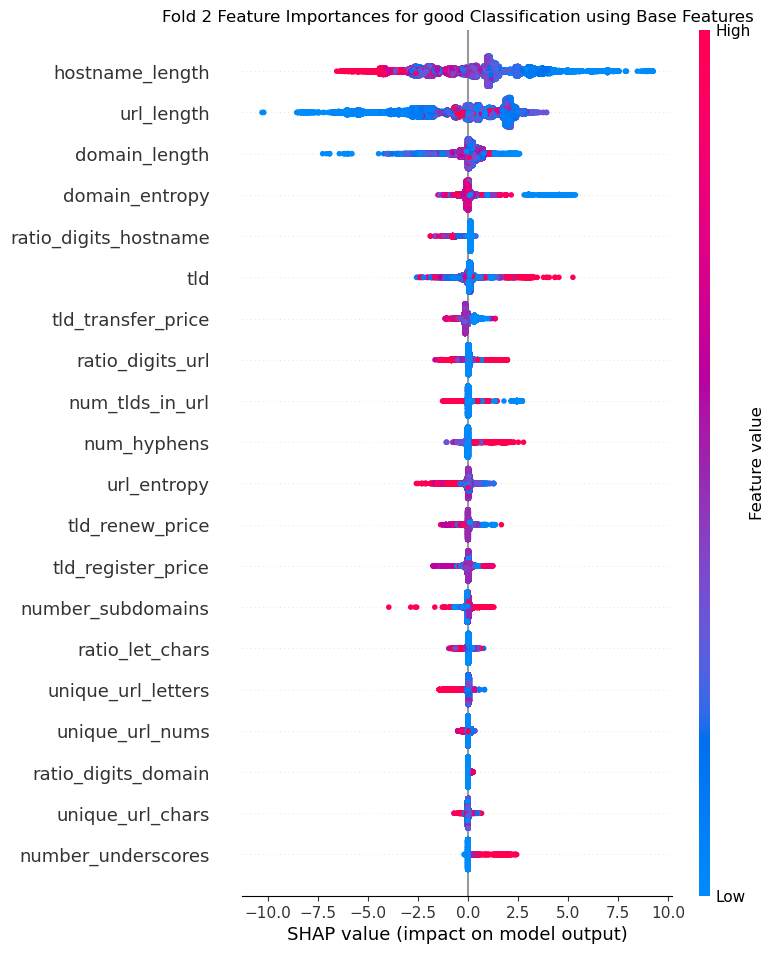

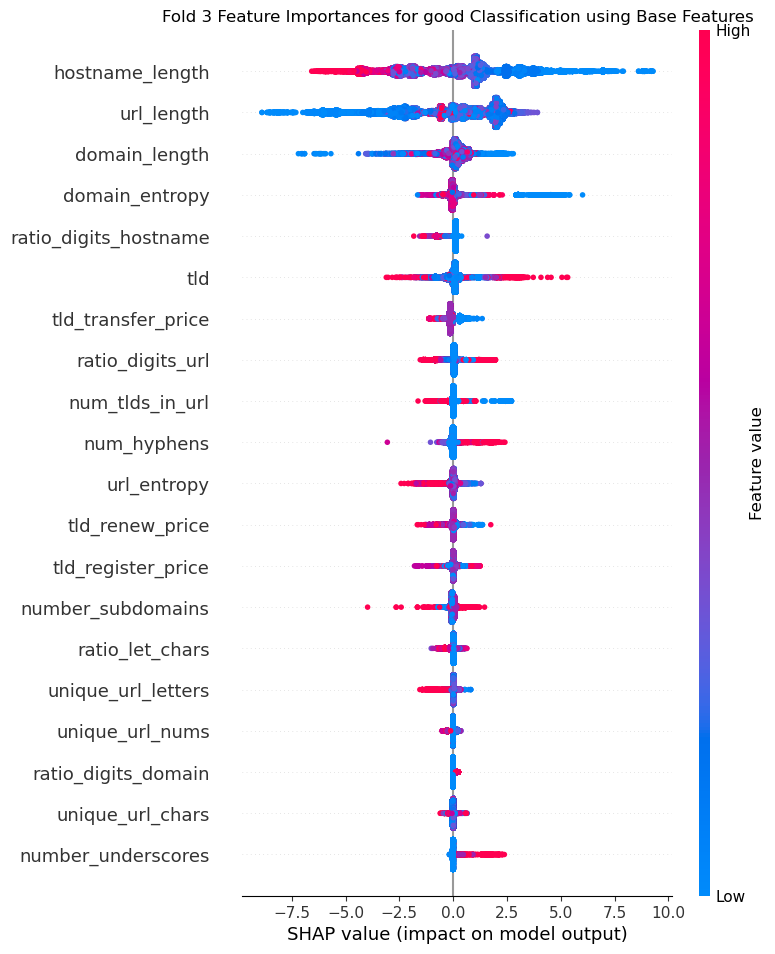

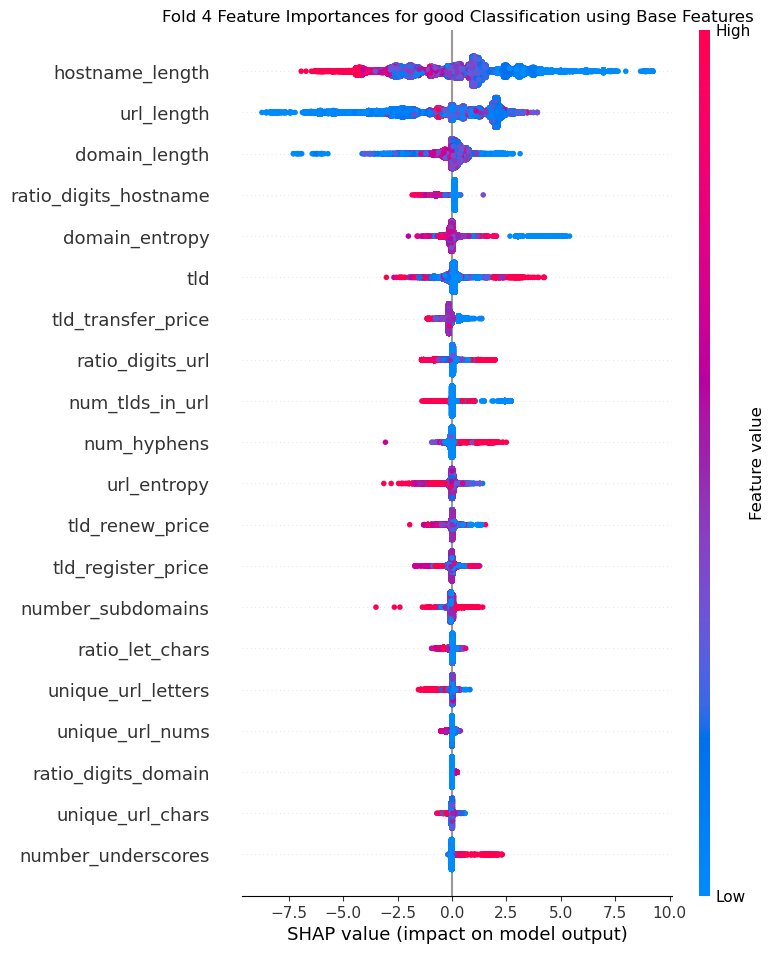

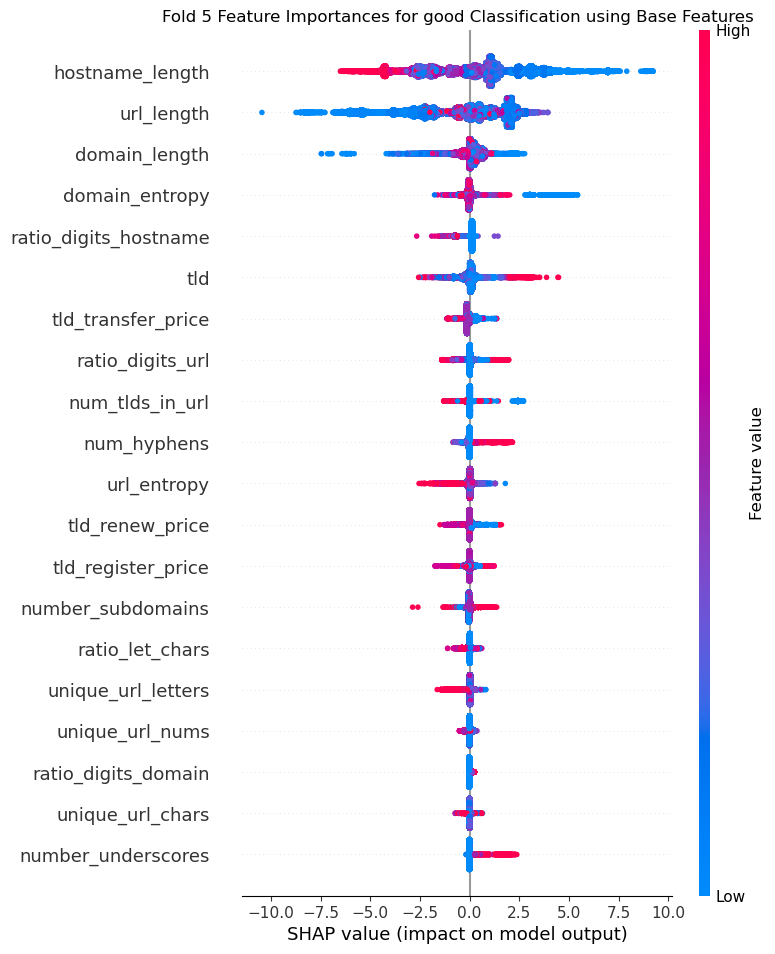

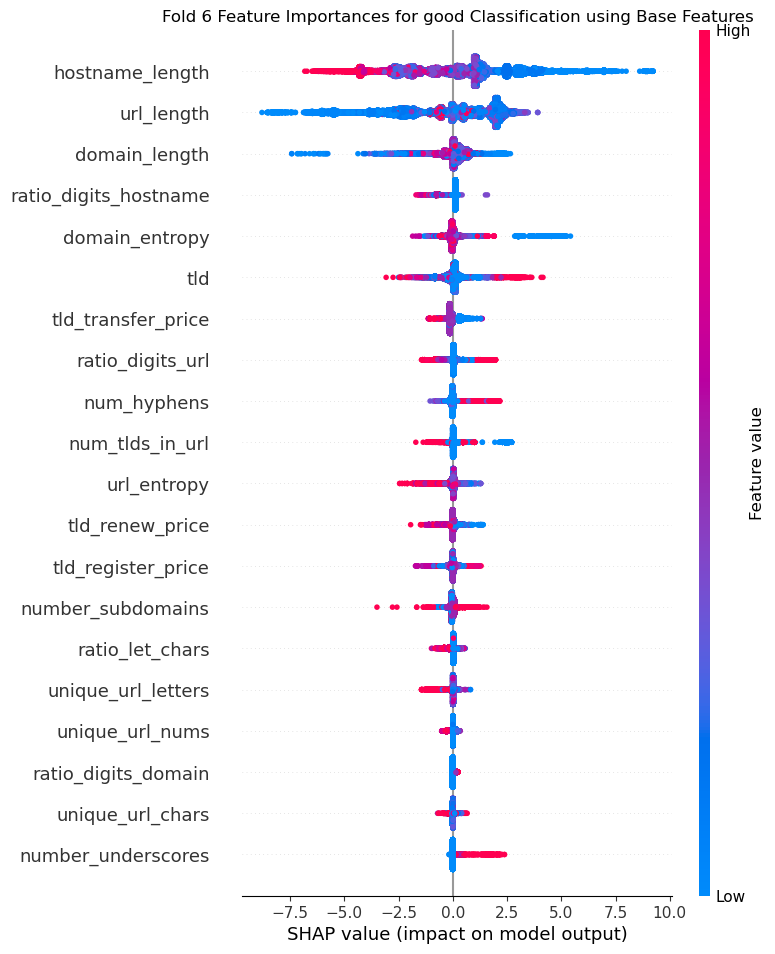

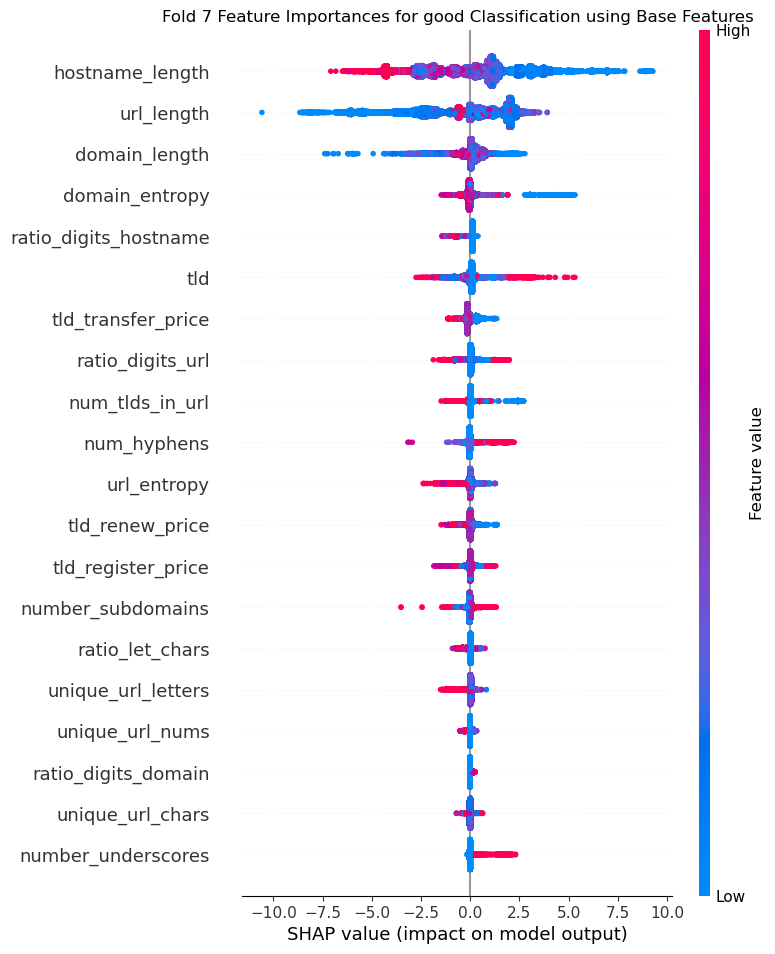

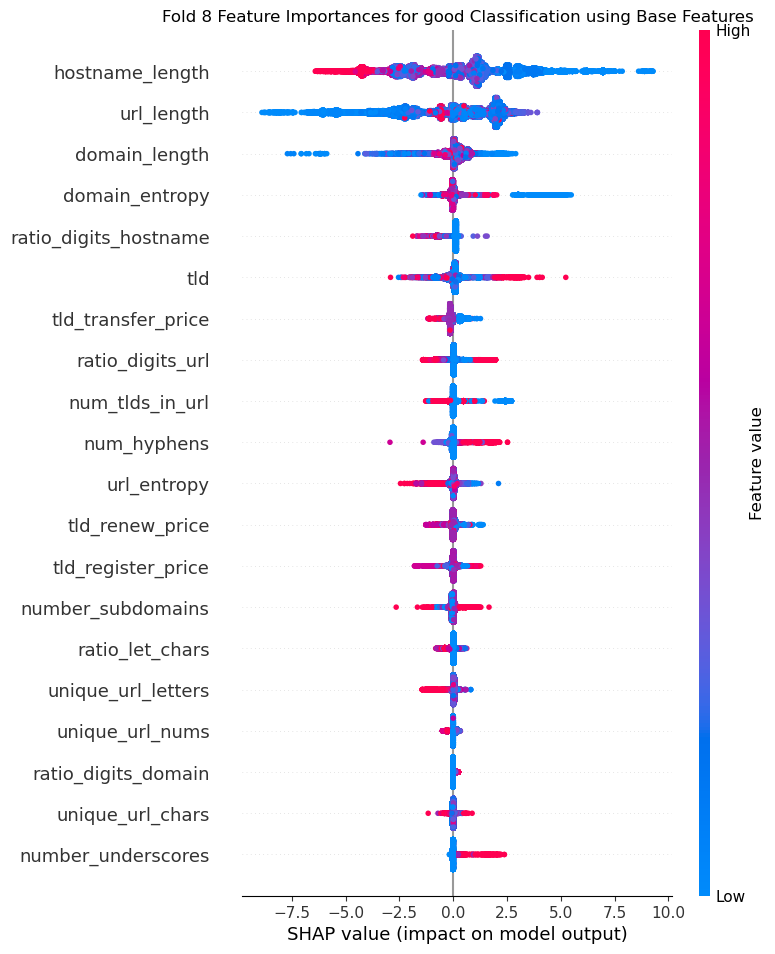

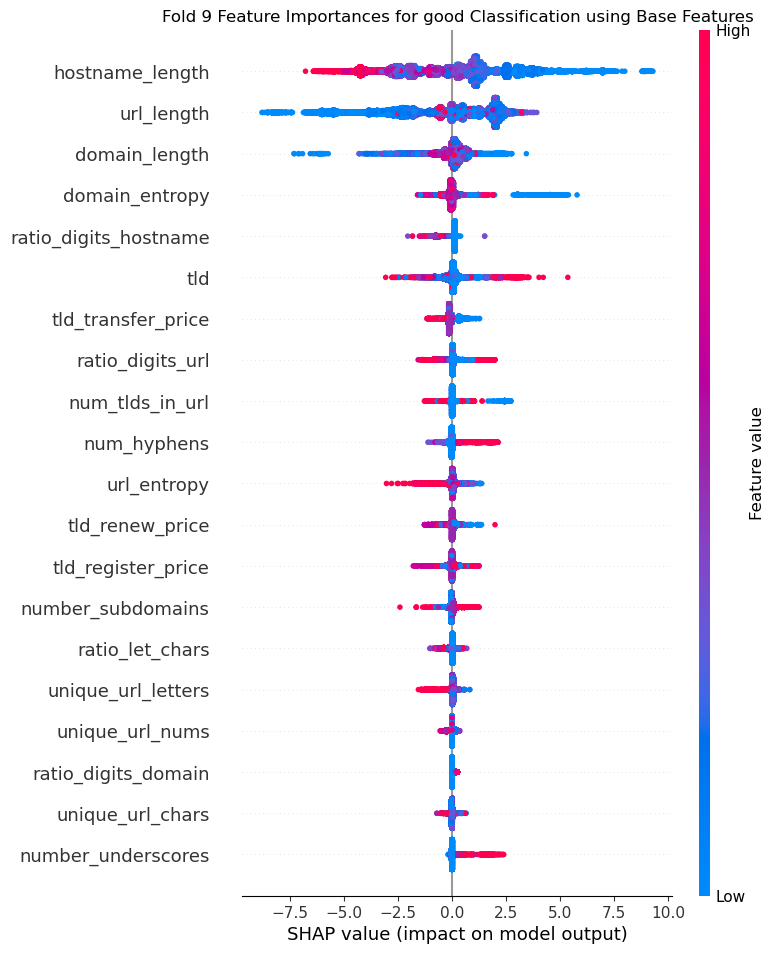

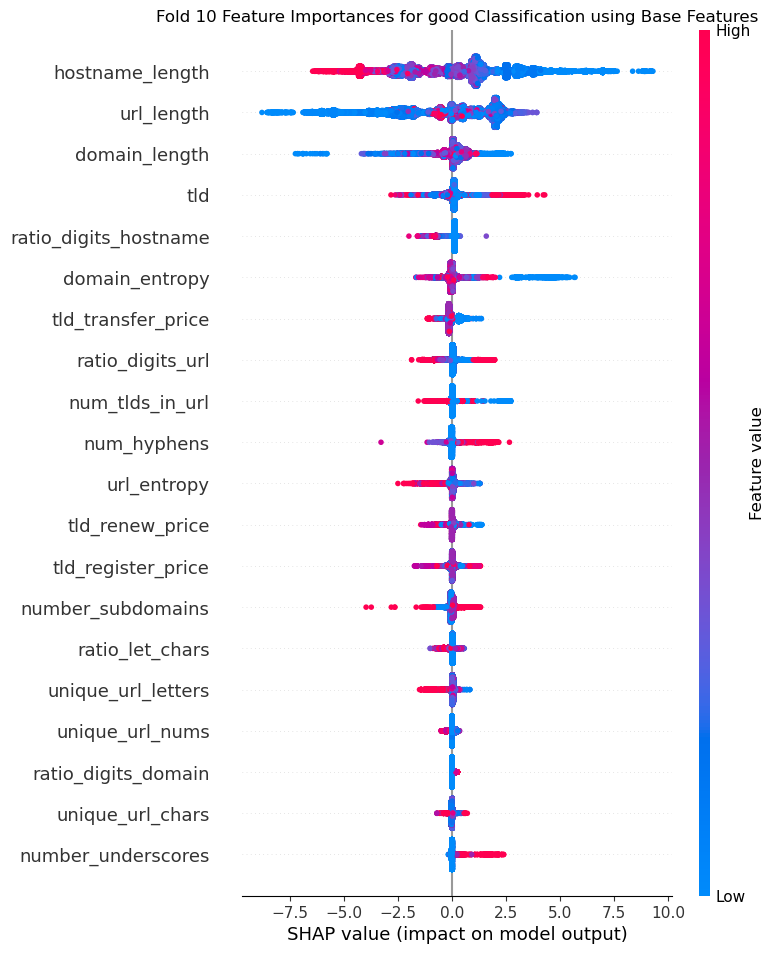

In [20]:
for i, X_test in enumerate(X_tests):
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_test, approximate=True)
    shap.summary_plot(shap_values[:,:,-1], X_test, max_display=20, show=False)
    plt.title(f"Fold {str(i + 1)} Feature Importances for good Classification using Base Features")
    plt.show()
    
    all_shap_values[FEATURE_GROUP].append((i + 1, shap_values, X_test))

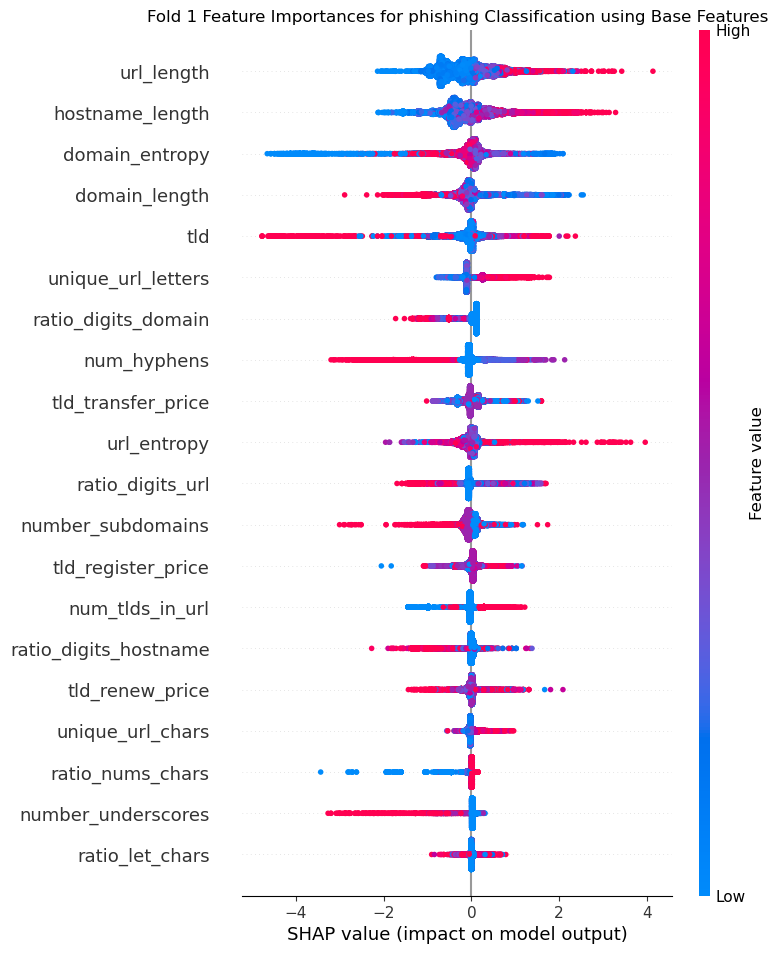

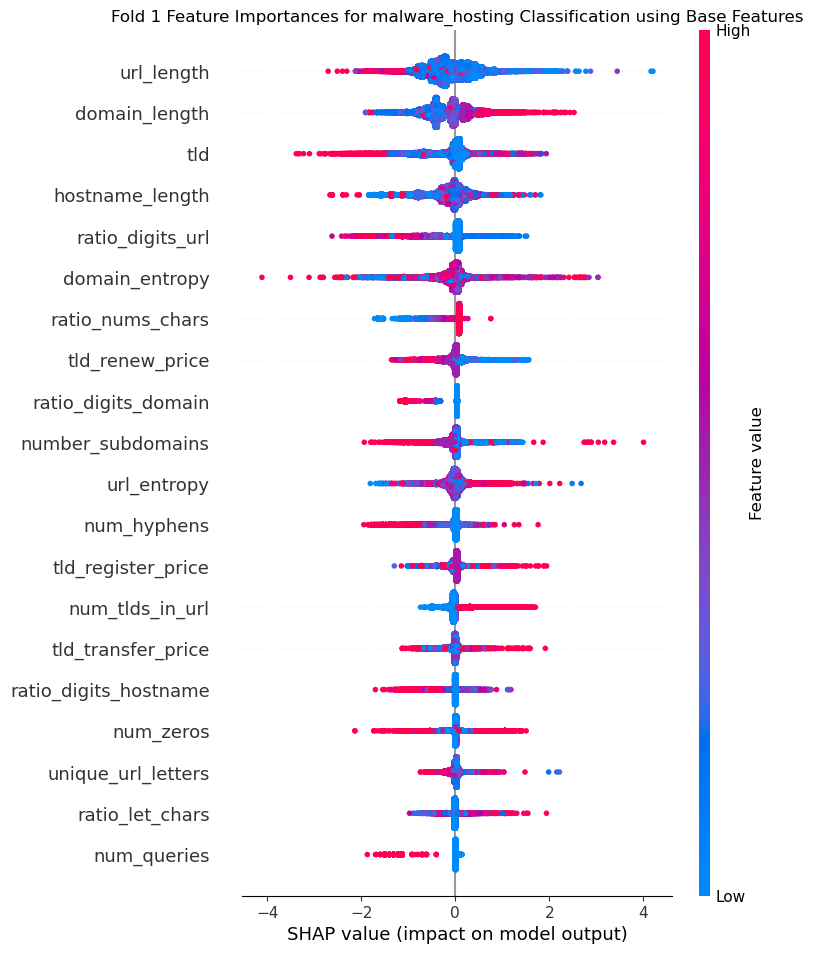

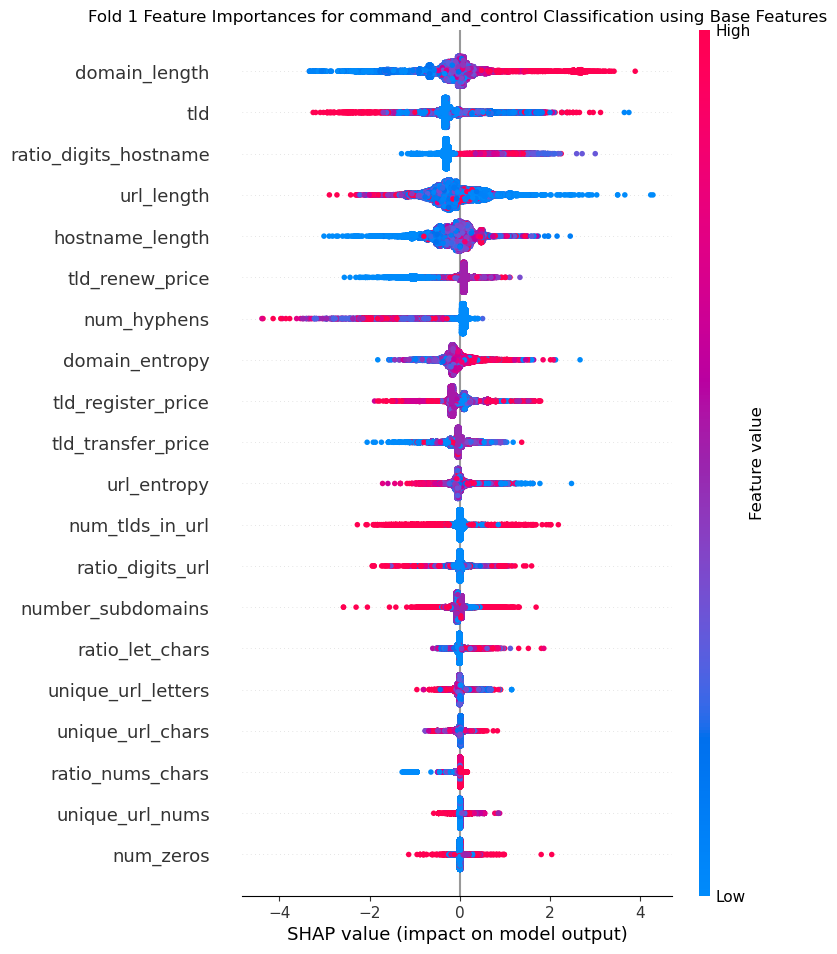

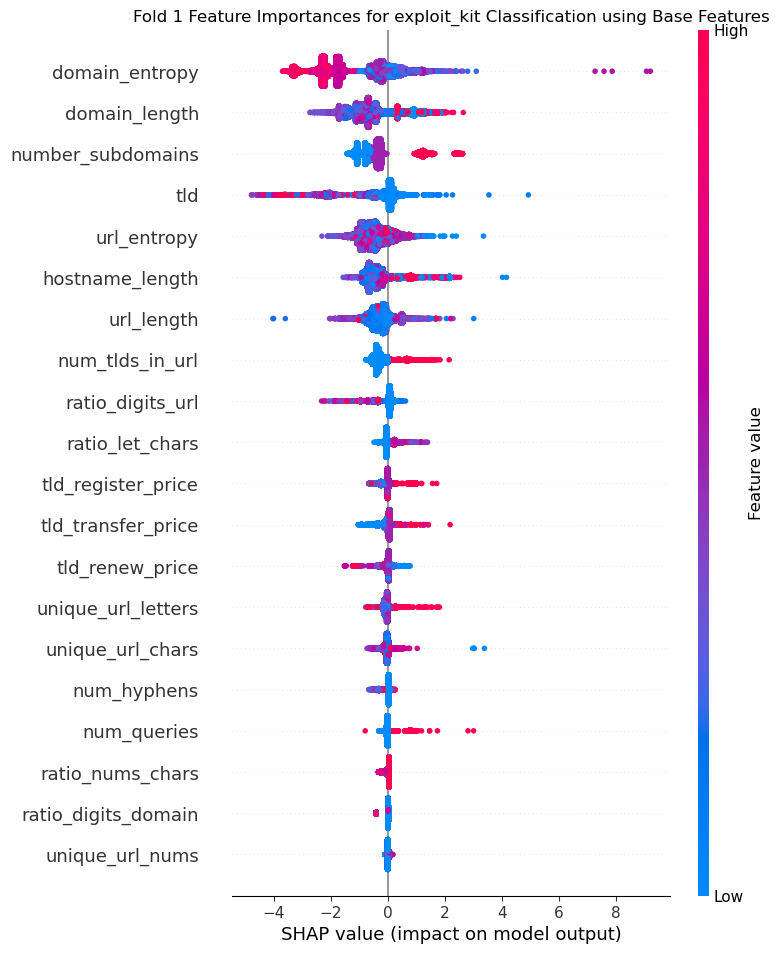

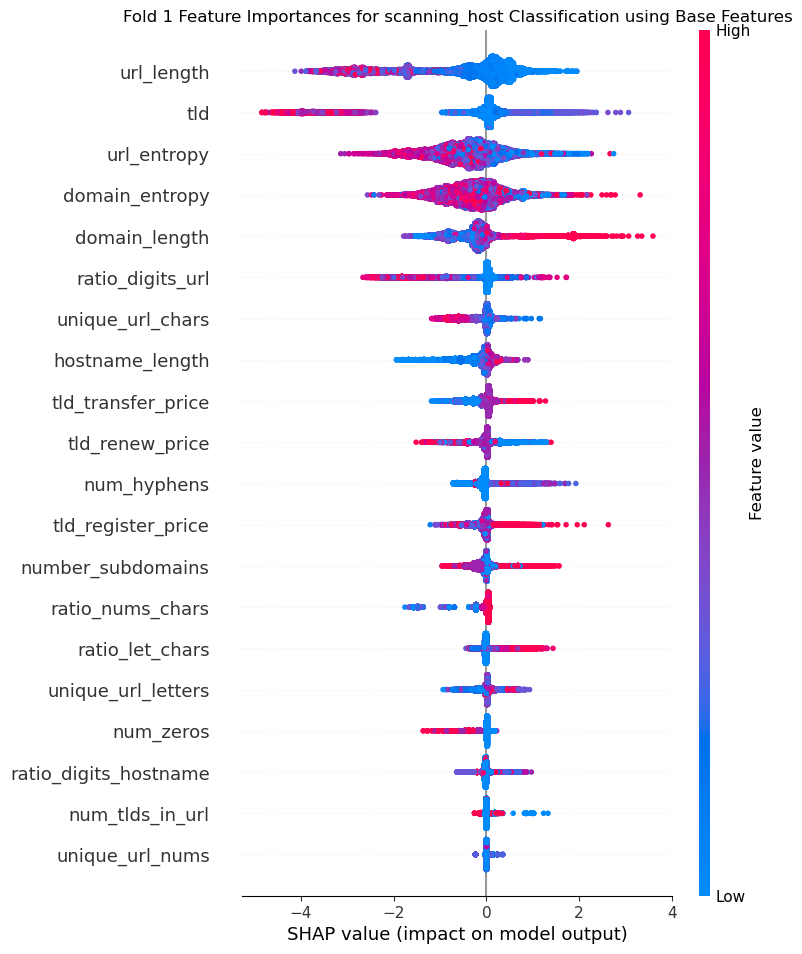

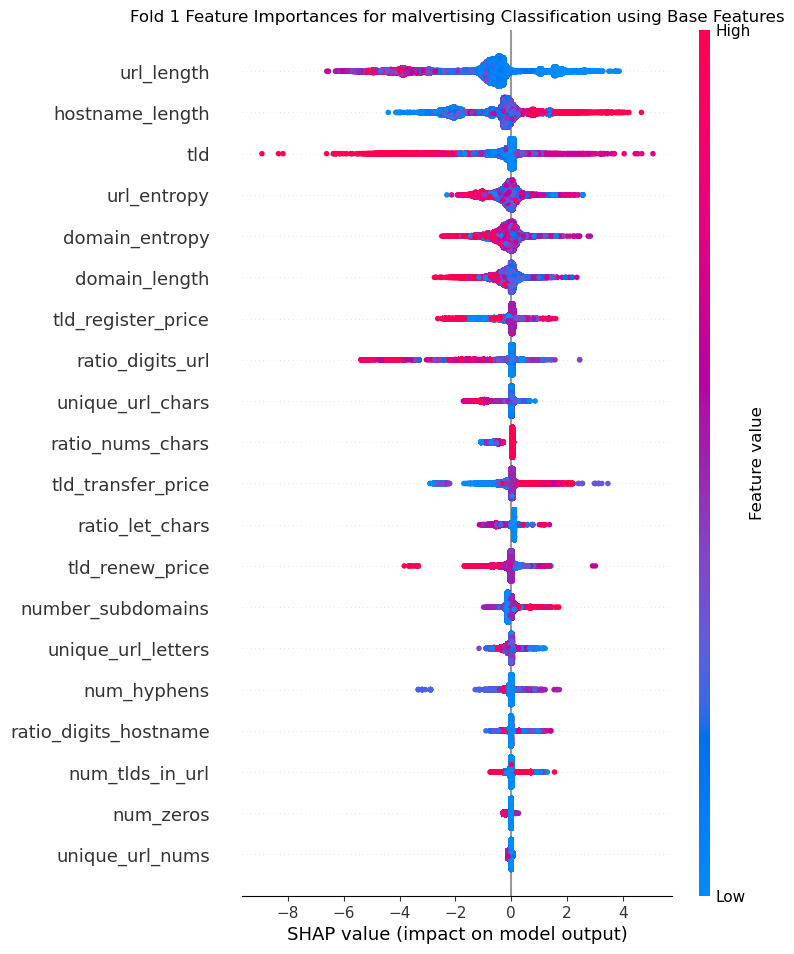

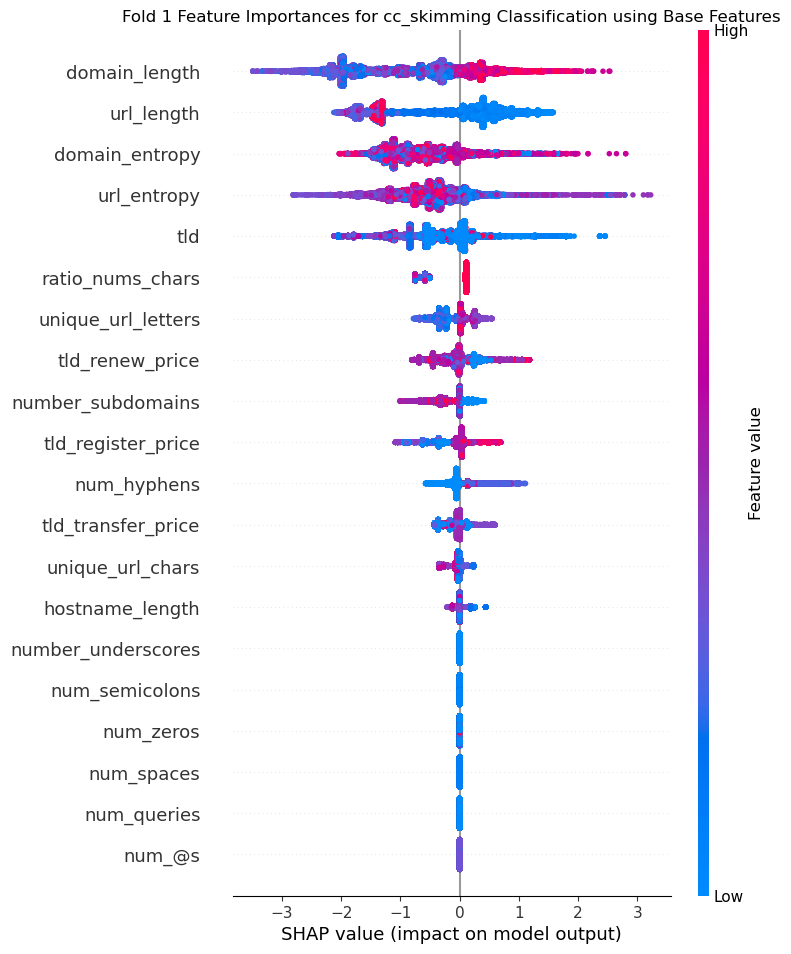

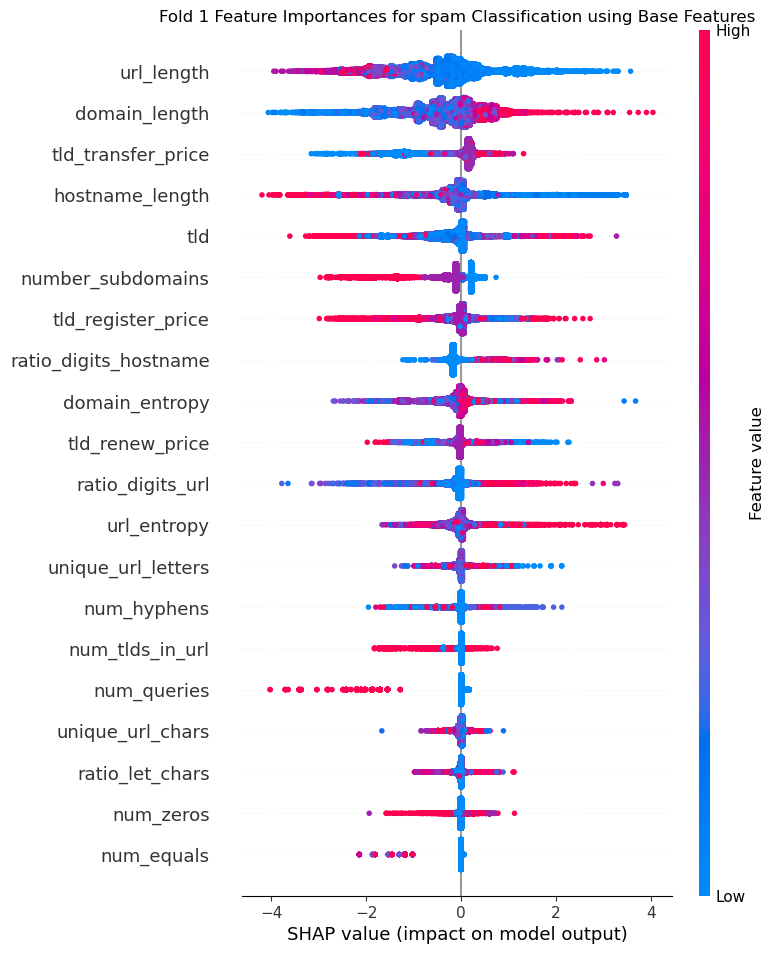

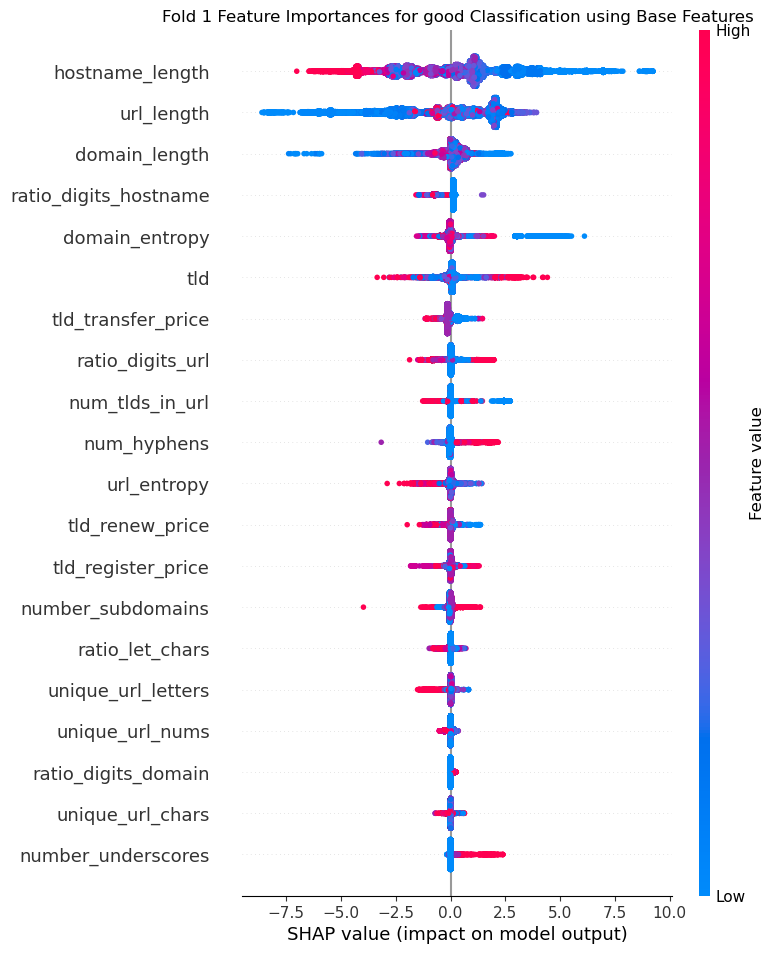

In [17]:
fold, shap_values, X_test = all_shap_values[FEATURE_GROUP][0]
for i, label in enumerate(labels):
    shap.summary_plot(shap_values[:,:,i], X_test, max_display=20, show=False)
    plt.title(f"Fold 1 Feature Importances for {label} Classification using Base Features")
    plt.show()

## Cascade 1

0
1
2
3
4
5
6
7
8
9


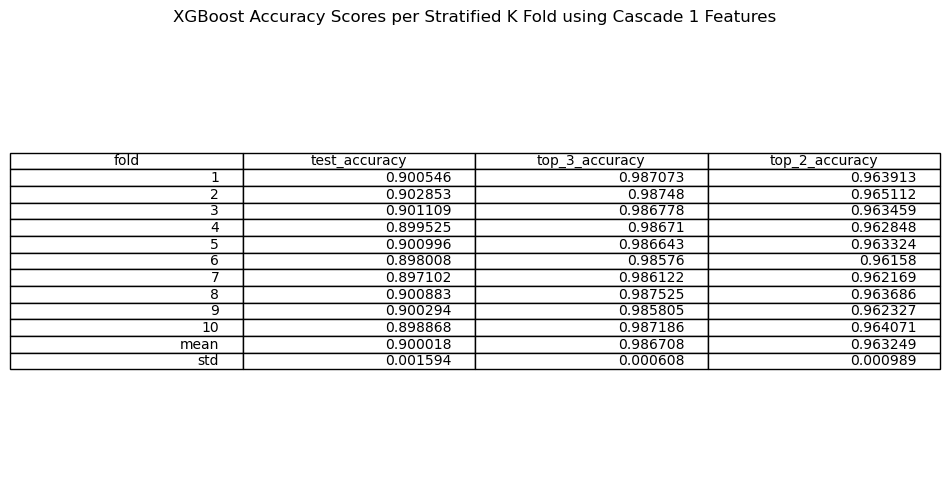

In [9]:
FEATURE_GROUP = "cascade_1"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using Cascade 1 Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [10]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
ratio_digits_domain       13.118795%               
ratio_digits_hostname     12.442552%               
domain_length             7.137394%                
hostname_length           7.037519%                
tld_transfer_price        6.880732%                
url_length                6.086037%                
num_hyphens               3.455447%                
unique_url_letters        3.434701%                
unique_url_nums           3.422092%                
ratio_nums_chars          3.174302%                
sitemap_count             3.105962%                
ratio_digits_url          2.926403%                
number_subdomains         2.627802%                
tld                       2.606585%                
robots_txt_len            2.406343%                
tld_renew_price           2.262194%                
tld_register_price        2.231385%                
num_tlds_in_url           2.074480%                
user_agent_c

## Cascade 2

0
1
2
3
4
5
6
7
8
9


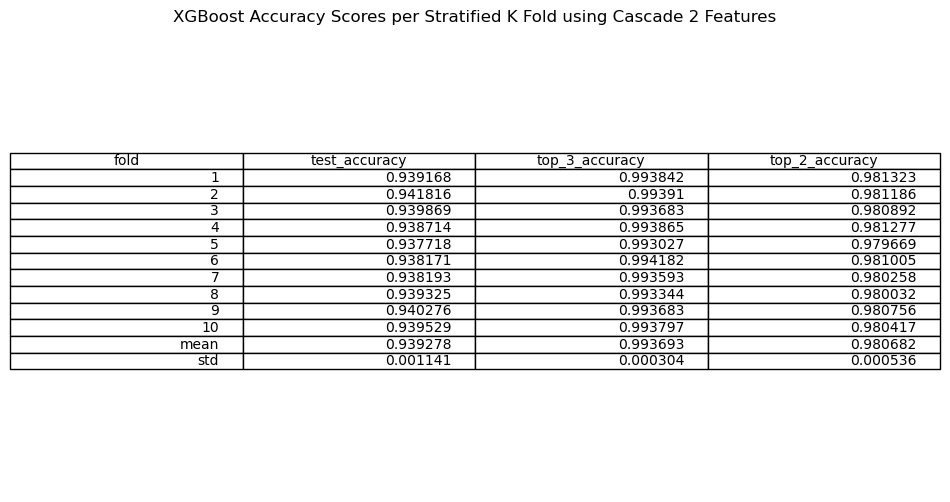

In [11]:
FEATURE_GROUP = "cascade_2"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using Cascade 2 Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [12]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
css_len                   18.163183%               
ratio_digits_domain       13.213356%               
external_css_len          8.340501%                
unique_url_letters        3.568656%                
ratio_digits_hostname     3.044805%                
domain_length             2.866794%                
tld_transfer_price        2.317274%                
hostname_length           2.195584%                
total_urls_in_html_count  2.187052%                
url_length                2.110235%                
num_hyphens               2.036018%                
ratio_digits_url          1.962600%                
number_subdomains         1.929596%                
tld_renew_price           1.904062%                
external_js_length        1.726801%                
ratio_nums_chars          1.715984%                
num_equals                1.702945%                
sitemap_count             1.620591%                
external_dom

## Cascade 3

0
1
2
3
4
5
6
7
8
9


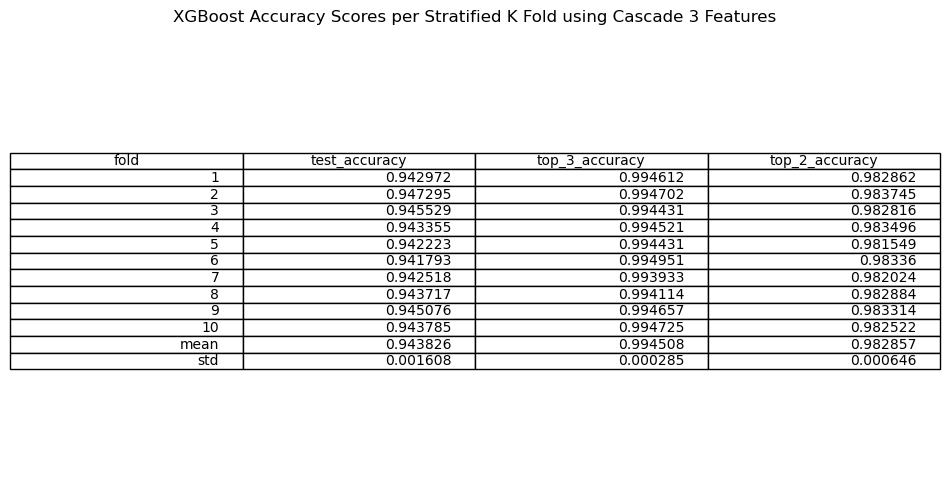

In [13]:
FEATURE_GROUP = "cascade_3"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using Cascade 3 Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [14]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
css_len                   18.223241%               
external_css_len          8.549869%                
ratio_digits_domain       8.049946%                
unique_hostnames_count    5.363004%                
img_srcs_count            2.388389%                
domain_length             2.384464%                
num_equals                2.259067%                
total_urls_in_html_count  2.255955%                
tld_transfer_price        2.063195%                
ratio_digits_hostname     2.032608%                
passive_dns_len           1.981814%                
url_length                1.823697%                
number_subdomains         1.800936%                
ratio_nums_chars          1.764766%                
ratio_digits_url          1.686133%                
hostname_length           1.665266%                
num_hyphens               1.653380%                
false_positive_asn_count  1.529055%                
sitemap_coun

## All Features

0
1
2
3
4
5
6
7
8
9


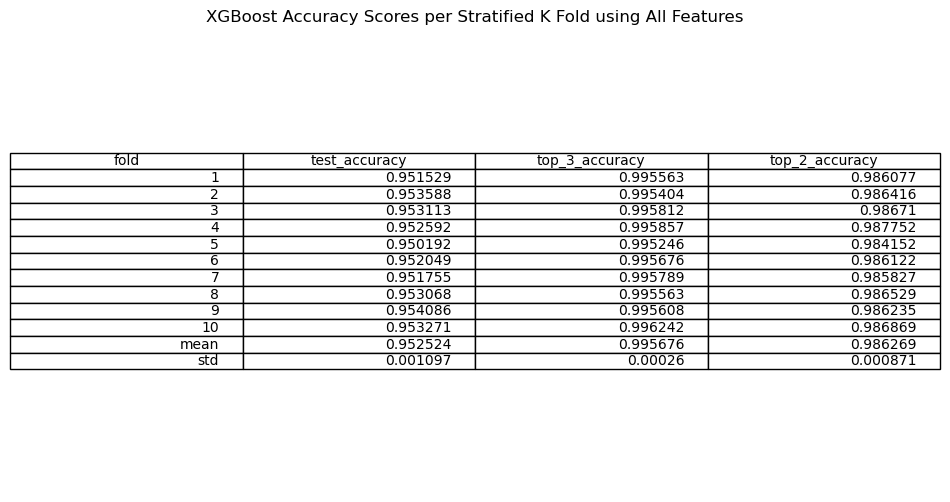

In [15]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1, 
                    max_depth=7, 
                    min_child_weight=1, 
                    n_estimators=165, 
                    colsample_bytree=1, 
                    colsample_bylevel=1, 
                    learning_rate=0.3, 
                    tree_method="exact",
                    booster="dart",
                    gamma=1e-10,
                    alpha=0,
                    subsample=1)

np.set_printoptions(precision=2)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))

    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

    X_tests.append(X_test)

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout
plt.title("XGBoost Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

all_accuracy_scores[FEATURE_GROUP] = scores

In [16]:
feat_imp = xgb.feature_importances_
feat_dict = {}

for i in range(len(feat_imp)):
    feat_dict[X.columns[i]] = feat_imp[i]
    
feat_dict = {k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}
    
print("{:<25} {:<25}".format('Feature' ,'Importance'))
for k, v in feat_dict.items():
    num = v
    print("{:<25} {:<25%}".format(k, num))

Feature                   Importance               
css_len                   16.257444%               
ratio_digits_domain       10.423560%               
external_css_len          8.053649%                
unique_hostnames_count    5.219170%                
registrar                 2.503060%                
num_equals                2.354853%                
domain_length             2.300583%                
total_urls_in_html_count  2.272072%                
img_srcs_count            2.209729%                
passive_dns_len           2.131458%                
tld_transfer_price        1.845837%                
num_hyphens               1.736148%                
ratio_digits_url          1.648372%                
hostname_length           1.611324%                
ratio_digits_hostname     1.575421%                
false_positive_asn_count  1.548406%                
ratio_nums_chars          1.503995%                
sitemap_count             1.386063%                
tld_renew_pr

In [ ]:
all_accuracy_scores = {}
all_shap_values = {"base_features": [], "cascade_1": [], "cascade_2": [], "cascade_3": [], "all_features": []}